In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
import rasterio
# import cdsapi
# c = cdsapi.Client()

In [3]:
# finding the extend of a shape file
# gdf = gpd.read_file(r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\New folder\new_temp.shp")
# extent = gdf.geometry.total_bounds
# print(extent)
# right_down_corver, left_up_corner = extent[:2], extent[2:]
# right_down_corver, left_up_corner


# find extend of raster file
def get_extent(input_path):
    with rasterio.open(input_path) as src:
        return src.bounds

input_path = r"G:\Pre-years\L4T1\HEC-HMS\Hec-Hms Project\parameter\Sub-Basin-Corrected\Sub_basin(WGS)_2.shp"
bounds = get_extent(input_path)
bounds = (max(bounds.bottom, bounds.top), min(bounds.left, bounds.right), min(bounds.top, bounds.bottom), max(bounds.left, bounds.right))
bounds = list(bounds)
bounds

RasterioIOError: 'G:/Pre-years/L4T1/HEC-HMS/Hec-Hms Project/parameter/Sub-Basin-Corrected/Sub_basin(WGS)_2.shp' not recognized as a supported file format.

In [5]:
# read the netcdf file
ds2 = xr.open_dataset(
    r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\17-20.nc",
    decode_times=True,
)
ds2

<xarray.Dataset>
Dimensions:    (longitude: 13, latitude: 13, time: 35064)
Coordinates:
  * longitude  (longitude) float32 87.99 88.24 88.49 88.74 ... 90.49 90.74 90.99
  * latitude   (latitude) float32 25.99 25.74 25.49 25.24 ... 23.49 23.24 22.99
  * time       (time) datetime64[ns] 2017-01-01 ... 2020-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-01 20:46:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
# finding all the point locations that are within  the boundaries
longitudes = ds2["longitude"].values
len_long = len(longitudes)
latitudes = ds2["latitude"].values
len_lat = len(latitudes)

points = []

for lon in longitudes:
    for lat in latitudes:
        points.append((lon, lat))

lat_long = np.array(points).reshape((len_lat, len_long, 2))
lat_long.shape

(13, 13, 2)

In [29]:
# # (obsolete , not used.)extracting point from basin shape file (just used for plotting)
# gdf = gpd.read_file(r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\Sub-Basin-Corrected\Sub_basin(WGS)_2.shp")
# geometries = gdf["geometry"]
# subbasin_name = gdf["name"]

# coordinates = []
# # coordinates_basins = []
# for geometry in geometries:
#     if geometry.geom_type == 'Polygon':
#         for point in geometry.exterior.coords[:]:
#             coordinates.append(list(point))
#     elif geometry.geom_type == 'MultiPolygon':
#         for polygon in geometry.geoms:
#             for point in polygon.exterior.coords[:]:
#                 coordinates.append(list(point))
#     # coordinates_basins.append(coordinates)
#     # print(type(coordinates))
#     # break
#     # coordinates = []
#     # break
# # coordinates_basins
# point_of_geometry = np.array(coordinates)
# point_of_geometry.shape

(67400, 2)

In [22]:
# # extracting point from basin shape file (just used for plotting)
gdf = gpd.read_file(r"C:\Users\User\Desktop\HEC-HMS\Hec-Hms Project\parameter\Sub-Basin-Corrected\Sub_basin(WGS)_2.shp")
geometries = gdf["geometry"]
subbasin_name = gdf["name"]

points_of_shape_file = np.empty((0,  2))
number_of_points_in_each_polygon = []
for geometry in geometries:
    if geometry.geom_type == 'Polygon':
        points_one_polygon = np.array(geometry.exterior.coords[:])
        number_of_points_in_each_polygon.append(len(points_one_polygon))
        points_of_shape_file = np.concatenate((points_of_shape_file, points_one_polygon), axis=0)
        
    elif geometry.geom_type == 'MultiPolygon':
        number_points_multi_polygon = []
        for polygon in geometry.geoms:
            points_one_polygon = np.array(polygon.exterior.coords[:])
            # number_points_multi_polygon.append(len(points_one_polygon))
            points_of_shape_file = np.concatenate((points_of_shape_file, points_one_polygon), axis=0)

            number_of_points_in_each_polygon.append(len(points_one_polygon))
            # number_of_points_in_each_polygon.append(sum(number_points_multi_polygon))

number_of_points_in_each_polygon = [sum(number_of_points_in_each_polygon[:i+1]) for i in range(len(number_of_points_in_each_polygon))]  # cumulative sum

In [24]:
# here is the flaw. I have increase the coordinate by 0.25 degree, because grid size is 0.25 degree. but in other cases grid may not 0.25 degree. 
# And also ther may be irregular grid size. 
# And also this portion of the code should be re-considered later.  
# this is the easiest code. But this is where i was stuck. I wonder why?

# creating rectangle around the data points
def create_rect(point, diff):
    return (
        [point[0] - diff, point[1] + diff],
        [point[0] + diff, point[1] + diff],
        [point[0] + diff, point[1] - diff],
        [point[0] - diff, point[1] - diff],
    )


rects = []
for point in lat_long.reshape(-1, 2):
    rects.append(list(create_rect(point, 0.25 / 2)))
rects = np.array(rects)
rects = rects.reshape(len_lat, len_long, 4, 2)
rects.shape

(13, 13, 4, 2)

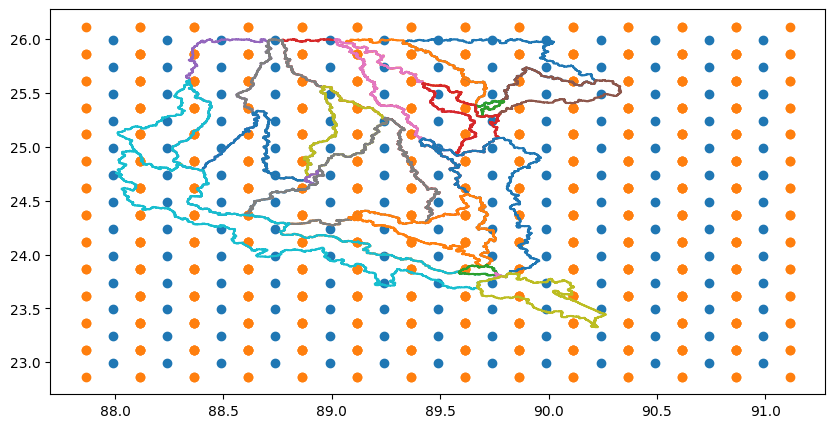

In [31]:
# plotting of the data points
plt.figure(figsize=(10,  5))

x, y = lat_long[:, :, 0], lat_long[:, :, 1]
plt.scatter(x, y)

# plotting of the rectangles
x, y = rects[:, :, :, 0], rects[:, :, :, 1]
plt.scatter(x, y)

# plotting of the sub-basins
for i, n in enumerate(number_of_points_in_each_polygon):
    if i == 0:
        x_p, y_p = points_of_shape_file[:n, 0], points_of_shape_file[:n, 1]
    else:
        x_p, y_p = (points_of_shape_file[number_of_points_in_each_polygon[i-1]:n, 0], 
                    points_of_shape_file[number_of_points_in_each_polygon[i-1]:n, 1])
        
    plt.plot(x_p, y_p, 
            #  label=f"{i +  1}"
             )

# plt.legend()
plt.show()